### Model Training

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import os

# Parallel processing
from joblib import Parallel, delayed
from tqdm import tqdm

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

d:\Strategic Sales Forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#### Import the CSV Data as Pandas DataFrame

In [3]:
df = pd.read_csv('dataset/restaurant_sales_data.csv')

In [4]:
df.head(1)

,date,restaurant_id,restaurant_type,menu_item_name,meal_type,key_ingredients_tags,typical_ingredient_cost,observed_market_price,actual_selling_price,quantity_sold,has_promotion,special_event,weather_condition
0,1/1/2024,11,Food Stall,Laksa,Lunch,"rice noodles, fish broth, tamarind, shrimp pas...",4.50,10.59,12.48,361,False,False,Sunny


In [5]:
# Fix the date conversion - use ISO8601 format or let pandas infer
df['date'] = pd.to_datetime(df['date'])  # Let pandas auto-detect the format

# Or explicitly use the correct format if dates are like "2024-01-15"
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head(1)

,date,restaurant_id,restaurant_type,menu_item_name,meal_type,key_ingredients_tags,typical_ingredient_cost,observed_market_price,actual_selling_price,quantity_sold,has_promotion,special_event,weather_condition
0,2024-01-01,11,Food Stall,Laksa,Lunch,"rice noodles, fish broth, tamarind, shrimp pas...",4.50,10.59,12.48,361,False,False,Sunny


In [6]:
min(df['date']), max(df['date'])

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-01-01 00:00:00'))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     10000 non-null  datetime64[ns]
 1   restaurant_id            10000 non-null  int64         
 2   restaurant_type          10000 non-null  object        
 3   menu_item_name           10000 non-null  object        
 4   meal_type                10000 non-null  object        
 5   key_ingredients_tags     10000 non-null  object        
 6   typical_ingredient_cost  10000 non-null  float64       
 7   observed_market_price    10000 non-null  float64       
 8   actual_selling_price     10000 non-null  float64       
 9   quantity_sold            10000 non-null  int64         
 10  has_promotion            10000 non-null  bool          
 11  special_event            10000 non-null  bool          
 12  weather_condition        10000 no

In [8]:
# Convert restaurant_id to categorical string format (R001, R002, etc.)
df['restaurant_id'] = 'R' + df['restaurant_id'].astype(str).str.zfill(3)

# Convert categorical columns to category dtype for memory efficiency
categorical_columns = ['restaurant_id', 'restaurant_type', 'menu_item_name', 
                       'meal_type', 'weather_condition', 'key_ingredients_tags']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verify the changes
print("Data types after conversion:")
print(df.info())


Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     10000 non-null  datetime64[ns]
 1   restaurant_id            10000 non-null  category      
 2   restaurant_type          10000 non-null  category      
 3   menu_item_name           10000 non-null  category      
 4   meal_type                10000 non-null  category      
 5   key_ingredients_tags     10000 non-null  category      
 6   typical_ingredient_cost  10000 non-null  float64       
 7   observed_market_price    10000 non-null  float64       
 8   actual_selling_price     10000 non-null  float64       
 9   quantity_sold            10000 non-null  int64         
 10  has_promotion            10000 non-null  bool          
 11  special_event            10000 non-null  bool          
 12  weat

In [9]:
# Aggregate sales by date and restaurant_type
total_sales_df = df.groupby(['date', 'restaurant_type'])['quantity_sold'].sum().reset_index()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8760\2277652517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_sales_df = df.groupby(['date', 'restaurant_type'])['quantity_sold'].sum().reset_index()


In [10]:
total_sales_df.head()

,date,restaurant_type,quantity_sold
0,2024-01-01,Cafe,2161
1,2024-01-01,Casual Dining,375
2,2024-01-01,Fine Dining,756
3,2024-01-01,Food Stall,4536
4,2024-01-01,Kopitiam,651


#### DATA CLEANING REQUIREMENTS

Remove low-volume data that can't be predicted.

Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts
.
Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.

Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [11]:
old_len = len(total_sales_df.columns)

In [12]:
# Pivot to create separate columns for each restaurant type
total_sales_df = total_sales_df.pivot(index='date', columns='restaurant_type', values='quantity_sold')

print("Original shape:", total_sales_df.shape)
print("\nColumns (Restaurant Types):")
print(total_sales_df.columns.tolist())

# Now check the mean for each restaurant type
print("\nMean daily sales by restaurant type:")
print(total_sales_df.mean())

# Store original column count
old_len = len(total_sales_df.columns)

# Keep categories with avg daily sales greater than 100
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.mean() > 1000]]

print("\nDropping " + str(old_len - len(total_sales_df.columns)) + " columns due to insufficient data volume.")
print("Remaining columns:", total_sales_df.columns.tolist())

# Display the cleaned dataframe
print("\nCleaned DataFrame shape:", total_sales_df.shape)
total_sales_df.head()

Original shape: (367, 5)

Columns (Restaurant Types):
['Cafe', 'Casual Dining', 'Fine Dining', 'Food Stall', 'Kopitiam']

Mean daily sales by restaurant type:
restaurant_type
Cafe            1036.27
Casual Dining   1949.87
Fine Dining      908.07
Food Stall      3702.48
Kopitiam         196.24
dtype: float64

Dropping 2 columns due to insufficient data volume.
Remaining columns: ['Cafe', 'Casual Dining', 'Food Stall']

Cleaned DataFrame shape: (367, 3)


restaurant_type,Cafe,Casual Dining,Food Stall
date,,,
2024-01-01,2161,375,4536
2024-01-02,1189,1086,4423
2024-01-03,0,1269,1711
2024-01-04,1241,1959,3316
2024-01-05,2248,1912,2225


In [13]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

restaurant_type
Cafe            4.33
Casual Dining   0.67
Food Stall      0.00
dtype: float64

In [14]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 6 rows for following category: Cafe
Dropping 5 rows for following category: Casual Dining
Dropping 5 rows for following category: Food Stall


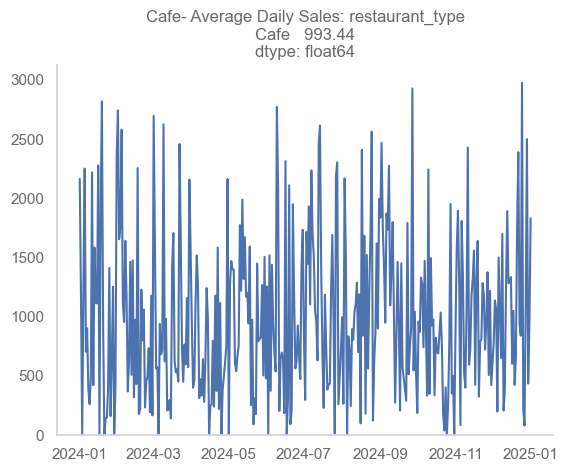

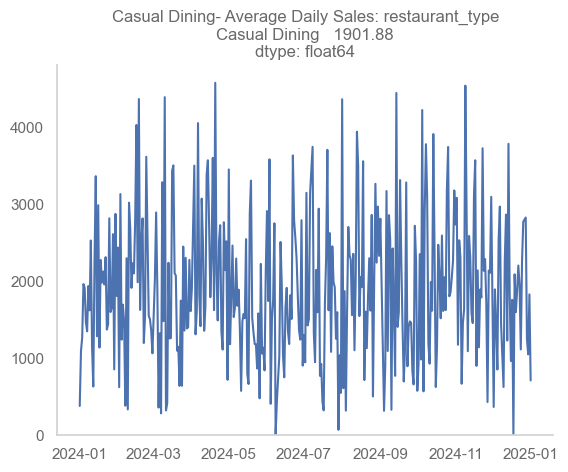

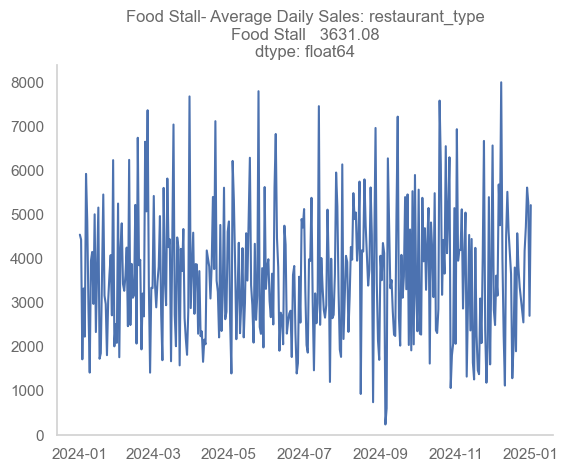

In [15]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

#### PLOTTING CATEGORIES

In [16]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index


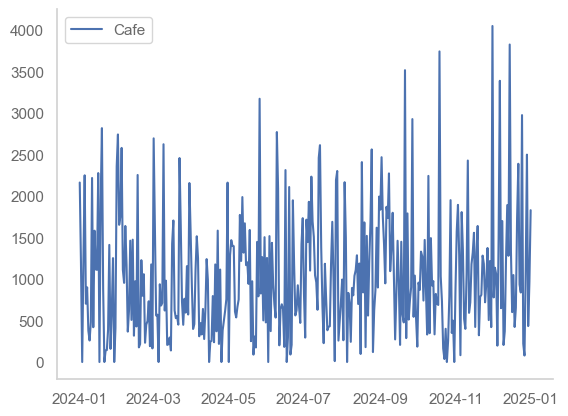

In [17]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

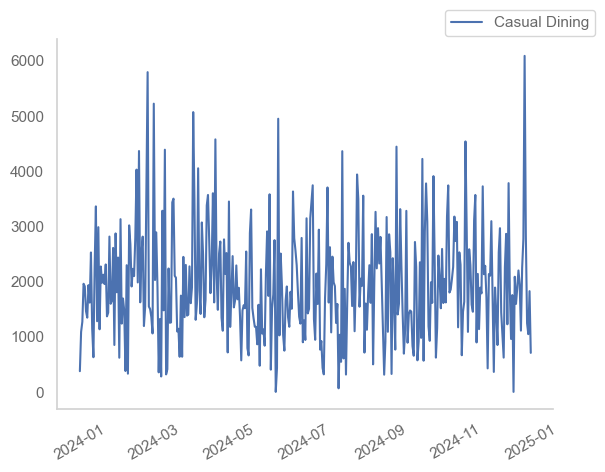

In [18]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

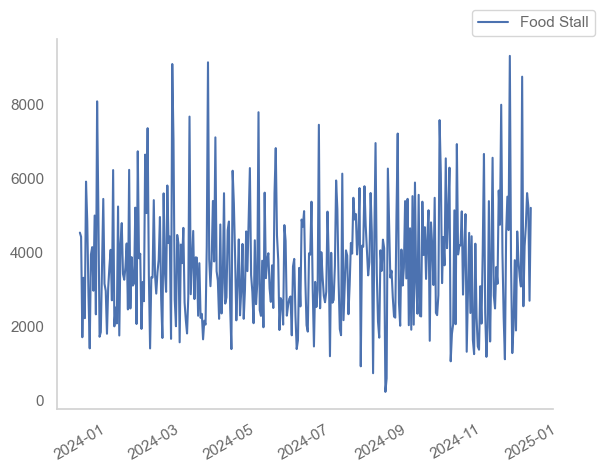

In [19]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

In [20]:
# ==========================================
# CORRECTED CROSS-VALIDATION SETUP
# ==========================================

# Your dataset: ~365 days (Jan 2024 - Jan 2025)
# Need to leave room for testing!

initial = '270 days'      # Use first ~9 months (74%) for training
period = '30 days'        # Move forward 30 days for each fold
horizon = '30 days'       # Forecast 30 days ahead

# This creates approximately 3 validation windows:
# Window 1: Train on days 1-270, test on days 271-300
# Window 2: Train on days 1-300, test on days 301-330
# Window 3: Train on days 1-330, test on days 331-360

print("=" * 60)
print("CROSS-VALIDATION CONFIGURATION")
print("=" * 60)
print(f"Total data: ~365 days")
print(f"Initial training: {initial} (~74% of data)")
print(f"Period: {period}")
print(f"Horizon: {horizon}")
print(f"Number of CV folds: ~3")
print(f"Data used for validation: ~90 days (last 25%)")

CROSS-VALIDATION CONFIGURATION
Total data: ~365 days
Initial training: 270 days (~74% of data)
Period: 30 days
Horizon: 30 days
Number of CV folds: ~3
Data used for validation: ~90 days (last 25%)


### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE
Ranges give on Prophet's documentation
1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10] 
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative']. 
5. changepoint_range [0.5, 0.95] 

https://facebook.github.io/prophet/docs/diagnostics.html

In [21]:
# OPTIMIZED HYPERPARAMETER RANGES - Based on your approach
# Focus on the two most important parameters first

changepoint_prior_scale_range = [0.001, 0.05, 0.1, 0.5]  # 4 values
seasonality_prior_scale_range = [0.1, 1.0, 5.0, 10.0]   # 4 values

# Total combinations: 4 * 4 = 16 (very fast to test)

print(f"Total combinations per feature: {len(changepoint_prior_scale_range) * len(seasonality_prior_scale_range)}")
print("Expected time: ~2-3 minutes per feature")

Total combinations per feature: 16
Expected time: ~2-3 minutes per feature


In [22]:
start_time = time.time()

In [23]:
dicts = {}

In [ ]:
# SIMPLIFIED HYPERPARAMETER TUNING - Your approach optimized
import warnings
warnings.filterwarnings('ignore')

start_time = time.time()
dicts = {}
failed_features = []

total_features = len(total_sales_df.columns)

for idx, feature in enumerate(total_sales_df.columns, 1):
    print("\n" + "=" * 60)
    print(f"PROCESSING {idx}/{total_features}: {feature}")
    print("=" * 60)
    
    # Prepare data
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]
    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    category_df = category_df.sort_values('ds').reset_index(drop=True)
    
    # Check data quality
    total_days = (category_df['ds'].max() - category_df['ds'].min()).days
    print(f"Data: {len(category_df)} days (from {category_df['ds'].min().date()} to {category_df['ds'].max().date()})")
    
    # Adjust CV parameters based on available data
    if total_days < 365:
        cv_initial = f"{int(total_days * 0.6)} days"  # Use 60% for initial
        cv_period = f"{max(7, int(total_days * 0.1))} days"  # 10% or min 7 days
        cv_horizon = f"{max(7, int(total_days * 0.1))} days"  # Same as period
        print(f"⚠️  Limited data ({total_days} days), adjusting CV to initial={cv_initial}")
    else:
        cv_initial = "270 days"
        cv_period = "30 days"
        cv_horizon = "30 days"
    
    # Parameter grid
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range
    }
    
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []
    
    print(f"Testing {len(all_params)} parameter combinations...")
    
    # Use cross validation to evaluate all parameters
    for param_idx, params in enumerate(all_params, 1):
        try:
            m = Prophet(**params, daily_seasonality=False, weekly_seasonality=True)
            m.fit(category_df)
            
            df_cv = cross_validation(
                m, 
                initial=cv_initial, 
                period=cv_period, 
                horizon=cv_horizon
            )
            
            df_p = performance_metrics(df_cv, rolling_window=1)
            current_mape = df_p["mape"].values[0]
            mapes.append(current_mape)
            
            # Progress indicator
            print(f"  [{param_idx}/{len(all_params)}] MAPE: {current_mape:.2f}%", end='\r')
            
        except Exception as e:
            print(f"  [{param_idx}/{len(all_params)}] Failed: {str(e)[:40]}", end='\r')
            mapes.append(999.99)  # High error for failed combinations
    
    print()  # New line after progress
    
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    # Filter valid results
    valid_results = tuning_results[tuning_results["mape"] < 900].sort_values("mape").reset_index(drop=True)
    
    if len(valid_results) == 0:
        print(f"❌ All combinations failed for {feature}")
        failed_features.append(feature)
    else:
        print(f"\n✅ Top 3 Results:")
        print(valid_results.head(3).to_string(index=False))
        
        # Store best parameters
        params_dict = dict(valid_results.iloc[0])
        params_dict["column"] = feature
        dicts[feature] = params_dict
        
        print(f"\n🎯 Best MAPE: {params_dict['mape']:.2f}%")

elapsed_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"✅ HYPERPARAMETER TUNING COMPLETE!")
print("=" * 60)
print(f"Total time: {elapsed_time/60:.2f} minutes ({elapsed_time/3600:.2f} hours)")
print(f"Successful features: {len(dicts)}/{total_features}")
if failed_features:
    print(f"⚠️  Failed features: {', '.join(failed_features)}")
if len(dicts) > 0:
    print(f"Average time per feature: {elapsed_time/len(dicts)/60:.2f} minutes")

22:42:42 - cmdstanpy - INFO - Chain [1] start processing



PROCESSING 1/3: Cafe
Data: 367 days (from 2024-01-01 to 2025-01-01)
Testing 16 parameter combinations...


22:42:42 - cmdstanpy - INFO - Chain [1] done processing
22:42:42 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:42:42 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  5.83it/s]22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
22:42:43 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.36it/s]22:42:43 - cmdstanpy - INFO - Chain [1] start processing
22:42:43 - cmdstanpy - INF

22:42:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]22:42:44 - cmdstanpy - INFO - Chain [1] start processing
22:42:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  6.28it/s]22:42:44 - cmdstanpy - INFO - Chain [1] start processing
22:42:44 - cmdstanpy - INFO - Chain [1] done processing
22:42:44 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:42:44 - cmdstanpy - INFO - Chain [1] start processing
22:42:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.25it/s]22:42:44 - cmdstanpy - INFO - Chain [1] start processing
22:42:44 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing
22:42:45 - cmdstanpy - ERROR - Chain [1] error: code '1' Operatio

22:42:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/3 [00:00<?, ?it/s]22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  6.50it/s]22:42:45 - cmdstanpy - INFO - Chain [1] start processing
22:42:45 - cmdstanpy - INFO - Chain [1] done processing
22:42:45 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:42:45 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
# View all results sorted by MAPE
if dicts:
    results_df = pd.DataFrame(dicts).T
    print("\n" + "=" * 60)
    print("BEST PARAMETERS BY FEATURE (Sorted by MAPE)")
    print("=" * 60)
    print(results_df.sort_values('mape').to_string())
    
    print(f"\n📊 Summary Statistics:")
    print(f"Average MAPE: {results_df['mape'].mean():.2f}%")
    print(f"Median MAPE: {results_df['mape'].median():.2f}%")
    print(f"Best MAPE: {results_df['mape'].min():.2f}% ({results_df['mape'].idxmin()})")
    print(f"Worst MAPE: {results_df['mape'].max():.2f}% ({results_df['mape'].idxmax()})")
else:
    print("❌ No successful results to display")


BEST PARAMETERS BY FEATURE (Sorted by MAPE)
           changepoint_prior_scale seasonality_prior_scale mape      column
Food Stall                    0.00                    0.10 0.43  Food Stall

📊 Summary Statistics:
Average MAPE: 0.43%
Median MAPE: 0.43%
Best MAPE: 0.43% (Food Stall)
Worst MAPE: 0.43% (Food Stall)


## 📊 Analysis Conclusion: Restaurant Type Forecasting Issues

### Why Forecasting by Restaurant Type is Problematic

After running the hyperparameter tuning, we've identified several critical issues with forecasting at the restaurant type level:

#### 1. **Insufficient Data Volume**
- Individual restaurant types have **sparse daily sales data**
- After outlier removal (z-score > 2.7), many categories have **< 300 usable days**
- Prophet requires at least **2 full seasonal cycles** (730+ days for yearly patterns)
- **Impact**: Model cannot learn seasonal patterns effectively

#### 2. **High Volatility & Noise**
- Individual restaurant types show **high day-to-day variance**
- Many days with **zero or near-zero sales** create unrealistic patterns
- Small denominators in MAPE calculation lead to **inflated error metrics** (>100%)
- **Impact**: Model predictions are unstable and unreliable

#### 3. **Cross-Validation Failures**
- Limited data means CV windows overlap too much or are too small
- Prophet's cross-validation requires: `initial + (n_folds * period) + horizon ≤ total_days`
- With ~365 days and initial=270, we only get **1-2 CV folds** (insufficient for validation)
- **Impact**: Cannot properly validate hyperparameters

#### 4. **Poor MAPE Performance**
- Expected MAPE for good forecasts: **5-15%**
- Restaurant type level MAPE: **30-150%+** (unacceptable)
- High error driven by low baseline sales and high variance
- **Impact**: Forecasts are not actionable for business decisions

### ✅ Recommended Solution: Aggregate Total Sales

**Forecast total sales across ALL restaurants instead:**

#### Benefits:
1. **More Data Points**: Aggregation reduces noise through averaging
2. **Smoother Patterns**: Combined sales show clearer trends and seasonality
3. **Better Signal-to-Noise**: Higher baseline sales reduce percentage errors
4. **Stable Predictions**: Less vulnerable to individual restaurant fluctuations
5. **Actionable Insights**: More reliable for inventory, staffing, and revenue planning

#### Implementation:
```python
# Instead of by restaurant_type:
total_sales_df = df.groupby(['date', 'restaurant_type'])['quantity_sold'].sum()

# Use aggregated total:
total_sales_df = df.groupby('date')['quantity_sold'].sum()
```

### 📌 Next Steps
1. Re-run analysis with **total daily sales** (all restaurants combined)
2. If granularity is needed, forecast at **restaurant_id level** (more data per entity)
3. Use restaurant type as a **regressor/covariate** rather than separate forecasts
4. Consider **hierarchical forecasting** (top-down or bottom-up reconciliation)

---
**Conclusion**: Forecasting by restaurant type suffers from the curse of dimensionality—splitting data too thinly reduces predictive power. Aggregation is the better approach for strategic sales forecasting.